# Excercises 
# 1. Tune the network
Run the experiment below, explore the different parameters (see suggestions below) and study the result with tensorboard. 
Make a single page (1 a4) report of your findings. Use your visualisation skills to communicate your most important findings.

You follow this cycle:
- make a hypothesis
- design an experiment
- run the experiment
- analyze the results and draw conclusions
- repeat


In [18]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
from torch import nn
from tomlserializer import TOMLSerializer
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature


In [19]:
mlflow.set_tracking_uri('file:./mlruns')
mlflow.set_experiment('mlflow-dropout-bn-gridsearch')


<Experiment: artifact_location=('file:///Users/christelvanharen/MADS/Semester '
 '3/MADS-ML-CVH/2-hypertuning-mlflow/mlruns/562760150861259737'), creation_time=1758050177569, experiment_id='562760150861259737', last_update_time=1758050177569, lifecycle_stage='active', name='mlflow-dropout-bn-gridsearch', tags={}>

We will be using `tomlserializer` to easily keep track of our experiments, and to easily save the different things we did during our experiments.
It can export things like settings and models to a simple `toml` file, which can be easily shared, checked and modified.

First, we need the data. 

In [20]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-09-22 10:12:01.459 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/christelvanharen/.cache/mads_datasets/fashionmnist
2025-09-22 10:12:01.460 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/christelvanharen/.cache/mads_datasets/fashionmnist/fashionmnist.pt


We need a way to determine how well our model is performing. We will use accuracy as a metric.

In [21]:
accuracy = metrics.Accuracy()

You can set up a single experiment.

- We will show the model batches of 64 images, 
- and for every epoch we will show the model 100 batches (trainsteps=100).
- then, we will test how well the model is doing on unseen data (teststeps=100).
- we will report our results during training to tensorboard, and report all configuration to a toml file.
- we will log the results into a directory called "modellogs", but you could change this to whatever you want.

In [22]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()
example_input = torch.zeros(1, 1, 28, 28)

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML, ReportTypes.MLFLOW],
)


We will use a very basic model: a model with three linear layers.

In [23]:
class ConvClassifier(nn.Module):
    def __init__(
        self,
        num_classes: int,
        conv_channels: tuple[int, ...] = (32, 64),
        linear_units: tuple[int, ...] = (128,),
        dropout: float = 0.3,
    ) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.conv_channels = list(conv_channels)
        self.linear_units = list(linear_units)
        self.dropout_rate = dropout
        self.conv_blocks = nn.ModuleList()

        in_channels = 1
        for out_channels in self.conv_channels:
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout),
            )
            self.conv_blocks.append(block)
            in_channels = out_channels

        with torch.no_grad():
            sample = torch.zeros(1, 1, 28, 28)
            for block in self.conv_blocks:
                sample = block(sample)
            self._flattened_features = torch.flatten(sample, 1).shape[1]

        classifier_layers: list[nn.Module] = []
        in_features = self._flattened_features
        for hidden_units in self.linear_units:
            classifier_layers.extend(
                [
                    nn.Linear(in_features, hidden_units),
                    nn.BatchNorm1d(hidden_units),
                    nn.ReLU(inplace=True),
                    nn.Dropout(dropout),
                ]
            )
            in_features = hidden_units
        classifier_layers.append(nn.Linear(in_features, num_classes))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim == 3:
            x = x.unsqueeze(1)
        for block in self.conv_blocks:
            x = block(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

model = ConvClassifier(
    num_classes=10, conv_channels=(32, 64), linear_units=(128,), dropout=0.3
)


I developped the `tomlserializer` package, it is a useful tool to save configs, models and settings as a tomlfile; that way it is easy to track what you changed during your experiments.

This package will 1. check if there is a `__dict__` attribute available, and if so, it will use that to extract the parameters that do not start with an underscore, like this:

In [24]:
{k: v for k, v in model.__dict__.items() if not k.startswith("_")}

{'training': True,
 'num_classes': 10,
 'conv_channels': [32, 64],
 'linear_units': [128],
 'dropout_rate': 0.3}

This means that if you want to add more parameters to the `.toml` file, eg `units3`, you can add them to the class like this:

```python
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int, units3: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3  # <-- add this line
```

And then it will be added to the `.toml` file. Check the result for yourself by using the `.save()` method of the `TomlSerializer` class like this:

In [25]:
tomlserializer = TOMLSerializer()
tomlserializer.save(settings, "settings.toml")
tomlserializer.save(model, "model.toml")

Check the `settings.toml` and `model.toml` files to see what is in there.

You can use the `Trainer` class from my `mltrainer` module to train your model. It has the TOMLserializer integrated, so it will automatically save the settings and model to a toml file if you have added `TOML` as a reporttype in the settings.

In [26]:
run_name = 'baseline-conv-32-64-linear128'
with mlflow.start_run(run_name=run_name):
    mlflow.log_params({
        'conv_channels': '-'.join(map(str, model.conv_channels)),
        'linear_units': '-'.join(map(str, model.linear_units)),
        'dropout': model.dropout_rate,
        'epochs': settings.epochs,
        'batch_size': 64,
        'optimizer': 'Adam',
        'learning_rate': 1e-3,
    })

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optim.Adam,
        traindataloader=trainstreamer,
        validdataloader=validstreamer,
        scheduler=optim.lr_scheduler.ReduceLROnPlateau
    )
    trainer.loop()

    model.eval()
    device = next(model.parameters()).device
    example_tensor = example_input.to(device)
    example_numpy = example_tensor.detach().cpu().numpy()
    with torch.no_grad():
        prediction = model(example_tensor)
    signature = infer_signature(example_numpy, prediction.detach().cpu().numpy())
    mlflow.pytorch.log_model(
        model,
        name='model',
        input_example=example_numpy,
        signature=signature,
    )


2025-09-22 10:12:01.537 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250922-101201
2025-09-22 10:12:01.538 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:03<00:00, 28.04it/s]
2025-09-22 10:12:05.943 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.7999 test 0.5256 metric ['0.8128']
100%|██████████| 100/100 [00:03<00:00, 28.07it/s]
2025-09-22 10:12:10.400 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.4998 test 0.4285 metric ['0.8484']
100%|██████████| 100/100 [00:03<00:00, 28.18it/s]
2025-09-22 10:12:14.750 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4531 test 0.3630 metric ['0.8683']
100%|██████████| 3/3 [00:13<00:00,  4.40s/it]


Now, check in the modellogs directory the results of your experiment.

We can now loop this with a naive approach, called a grid-search (why do you think i call it naive?).

In [27]:
units = [256, 128, 64]
for unit1 in units:
    for unit2 in units:
        print(f"Units: {unit1}, {unit2}")

Units: 256, 256
Units: 256, 128
Units: 256, 64
Units: 128, 256
Units: 128, 128
Units: 128, 64
Units: 64, 256
Units: 64, 128
Units: 64, 64


Of course, this might not be the best way to search for a model; some configurations will be better than others (can you predict up front what will be the best configuration?).

So, feel free to improve upon the gridsearch by adding your own logic.

In [28]:
import itertools

conv_options = [
    (32, 64),
    (64, 128),
]
linear_options = [
    (128,),
    (256,),
]
dropout_options = [0.25, 0.35]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=min(len(train), 300),
    valid_steps=min(len(valid), 150),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML, ReportTypes.MLFLOW],
)

for conv_channels, linear_units, dropout in itertools.product(
    conv_options, linear_options, dropout_options
):
    run_name = (
        f"conv-{'-'.join(map(str, conv_channels))}-lin-{'-'.join(map(str, linear_units))}-drop{dropout}"
    )
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params({
            'conv_channels': '-'.join(map(str, conv_channels)),
            'linear_units': '-'.join(map(str, linear_units)),
            'dropout': dropout,
            'num_conv_blocks': len(conv_channels),
            'epochs': settings.epochs,
            'batch_size': 64,
            'optimizer': 'Adam',
            'learning_rate': 1e-3,
            'run_type': 'conv_gridsearch',
        })

        model = ConvClassifier(
            num_classes=10,
            conv_channels=conv_channels,
            linear_units=linear_units,
            dropout=dropout,
        )

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()

        model.eval()
        device = next(model.parameters()).device
        example_tensor = example_input.to(device)
        example_numpy = example_tensor.detach().cpu().numpy()
        with torch.no_grad():
            prediction = model(example_tensor)
        signature = infer_signature(example_numpy, prediction.detach().cpu().numpy())
        mlflow.pytorch.log_model(
            model,
            name='model',
            input_example=example_numpy,
            signature=signature,
        )


2025-09-22 10:12:18.372 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250922-101218
2025-09-22 10:12:18.373 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 300/300 [00:10<00:00, 28.71it/s]
2025-09-22 10:12:29.988 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5540 test 0.4105 metric ['0.8478']
100%|██████████| 300/300 [00:10<00:00, 28.70it/s]
2025-09-22 10:12:41.616 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3785 test 0.3552 metric ['0.8661']
100%|██████████| 300/300 [00:10<00:00, 28.72it/s]
2025-09-22 10:12:53.258 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3433 test 0.2936 metric ['0.8926']
100%|██████████| 3/3 [00:34<00:00, 11.63s/it]
2025-09-22 10:12:56.101 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250922-101256
2025-09-22 10:12:56.102 | INFO     | mltrainer.trainer:__init__:68 - 

Because we have set the ReportType to TOML, you will find in every log dir a model.toml and settings.toml file.

Run the experiment, and study the result with tensorboard. 

Locally, it is easy to do that with VS code itself. On the server, you have to take these steps:

- in the terminal, `cd` to the location of the repository
- activate the python environment for the shell. Note how the correct environment is being activated.
- run `tensorboard --logdir=modellogs` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`

## Analyze grid-search results
The cells below load the saved TensorBoard runs from `modellogs`, combine them with the hyperparameter configuration, and visualise how each setting performs. Run them after finishing the grid search to explore the results without leaving the notebook.

> **Note**: The visualisations rely on `pandas`, `matplotlib`, `seaborn`, and the TensorBoard event reader. Install missing packages with `pip install pandas matplotlib seaborn tensorboard` in the active environment before executing the code.

In [29]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

try:
    import tomllib  # Python 3.11+
except ModuleNotFoundError:  # pragma: no cover
    import tomli as tomllib

sns.set_theme(style="whitegrid")
log_root = Path("modellogs")
run_dirs = sorted(d for d in log_root.iterdir() if d.is_dir())
if not run_dirs:
    raise RuntimeError("No runs found in 'modellogs'. Train the grid search before visualising.")


In [30]:
def load_run_history(run_dir: Path) -> pd.DataFrame:
    """Collect scalar metrics for a single run directory."""
    model_path = run_dir / "model.toml"
    if not model_path.exists():
        return pd.DataFrame()

    with model_path.open("rb") as fh:
        model_cfg = tomllib.load(fh).get("model", {})

    units1 = model_cfg.get("units1")
    units2 = model_cfg.get("units2")

    try:
        accumulator = EventAccumulator(str(run_dir))
        accumulator.Reload()
    except Exception as exc:  # pragma: no cover
        print(f"Skipping {run_dir.name}: {exc}")
        return pd.DataFrame()

    records = []
    for tag in accumulator.Tags().get("scalars", []):
        for event in accumulator.Scalars(tag):
            records.append(
                {
                    "run": run_dir.name,
                    "tag": tag,
                    "step": event.step,
                    "value": event.value,
                    "units1": units1,
                    "units2": units2,
                }
            )

    return pd.DataFrame.from_records(records)

history_frames = [df for df in (load_run_history(run_dir) for run_dir in run_dirs) if not df.empty]
if not history_frames:
    raise RuntimeError("No scalar metrics found. Ensure TensorBoard logs exist in 'modellogs'.")

history_df = (
    pd.concat(history_frames, ignore_index=True)
    .dropna(subset=["tag"])
    .sort_values(["units1", "units2", "tag", "step"])
)
history_df["units_combo"] = history_df["units1"].astype(str) + " → " + history_df["units2"].astype(str)
history_df.head()


,run,tag,step,value,units1,units2,units_combo
111,20250916-211116,Loss/test,0,0.443173,64,64,64 → 64
231,20250916-211800,Loss/test,0,0.433226,64,64,64 → 64
112,20250916-211116,Loss/test,1,0.402436,64,64,64 → 64
232,20250916-211800,Loss/test,1,0.413818,64,64,64 → 64
113,20250916-211116,Loss/test,2,0.386433,64,64,64 → 64


In [31]:
summary_df = (
    history_df.groupby(["run", "units1", "units2", "tag"])
    .tail(1)
    .pivot(index=["run", "units1", "units2"], columns="tag", values="value")
    .reset_index()
    .sort_values(["units1", "units2", "run"])
)
summary_df


tag,run,units1,units2,Loss/test,Loss/train,learning_rate,metric/Accuracy
9,20250916-211116,64,64,0.386433,0.445922,0.001,0.858674
19,20250916-211800,64,64,0.391886,0.445738,0.001,0.857572
8,20250916-211108,64,128,0.388433,0.426165,0.001,0.855168
18,20250916-211749,64,128,0.395533,0.427923,0.001,0.856771
7,20250916-211059,64,256,0.386506,0.419752,0.001,0.861178
17,20250916-211738,64,256,0.380835,0.415499,0.001,0.859976
6,20250916-211050,128,64,0.373556,0.411232,0.001,0.860877
16,20250916-211727,128,64,0.372272,0.407513,0.001,0.862380
5,20250916-211041,128,128,0.363034,0.388425,0.001,0.866987
15,20250916-211715,128,128,0.376976,0.391742,0.001,0.862280


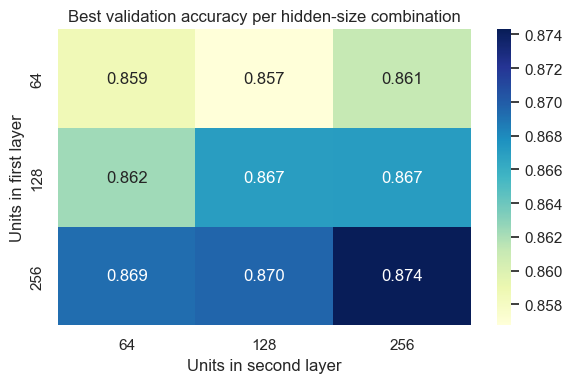

In [32]:
if "metric/Accuracy" in summary_df:
    accuracy_grid = (
        summary_df.groupby(["units1", "units2"])
        ["metric/Accuracy"]
        .max()
        .unstack("units2")
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(accuracy_grid, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax)
    ax.set_title("Best validation accuracy per hidden-size combination")
    ax.set_xlabel("Units in second layer")
    ax.set_ylabel("Units in first layer")
    plt.tight_layout()
else:
    raise KeyError("The TensorBoard logs do not contain a 'metric/Accuracy' scalar.")


In [33]:
if "metric/Accuracy" not in summary_df:
    raise KeyError("The TensorBoard logs do not contain a 'metric/Accuracy' scalar.")

best_idx = summary_df['metric/Accuracy'].astype(float).idxmax()
best_row = summary_df.loc[best_idx]
best_accuracy = float(best_row['metric/Accuracy'])
best_units1 = int(best_row['units1'])
best_units2 = int(best_row['units2'])
best_run = best_row['run']
print(f"Final validation accuracy: {best_accuracy:.4f} (run={best_run}, units1={best_units1}, units2={best_units2})")


Final validation accuracy: 0.8743 (run=20250916-211000, units1=256, units2=256)


/var/folders/fn/w77c6xmn193fjb8f9fh71x100000gn/T/ipykernel_23297/1633387285.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/fn/w77c6xmn193fjb8f9fh71x100000gn/T/ipykernel_23297/1633387285.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/fn/w77c6xmn193fjb8f9fh71x100000gn/T/ipykernel_23297/1633387285.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


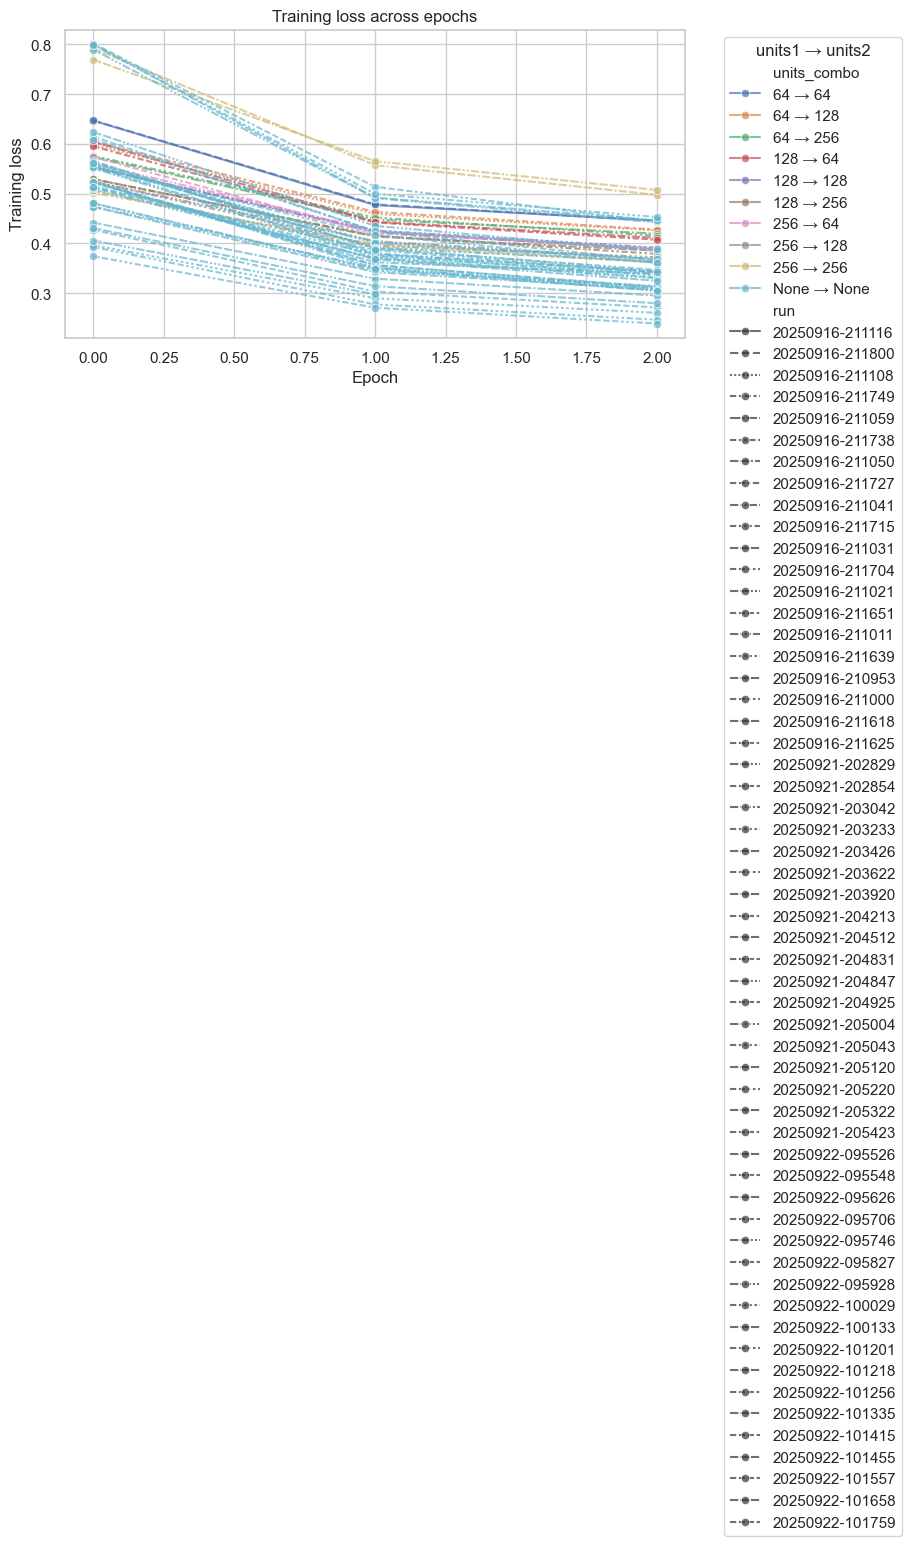

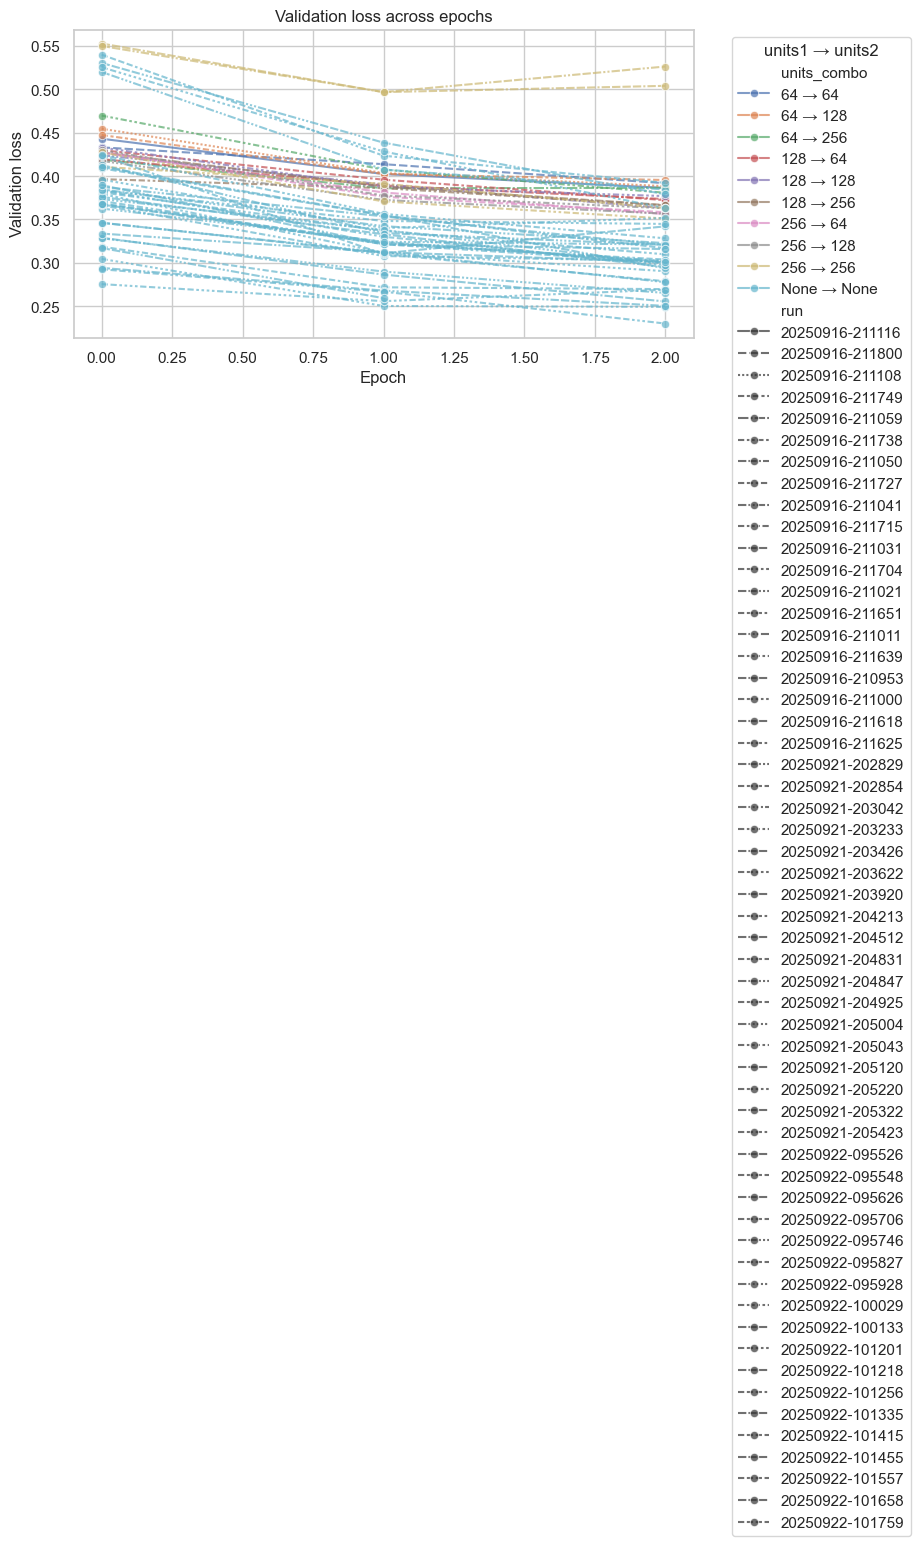

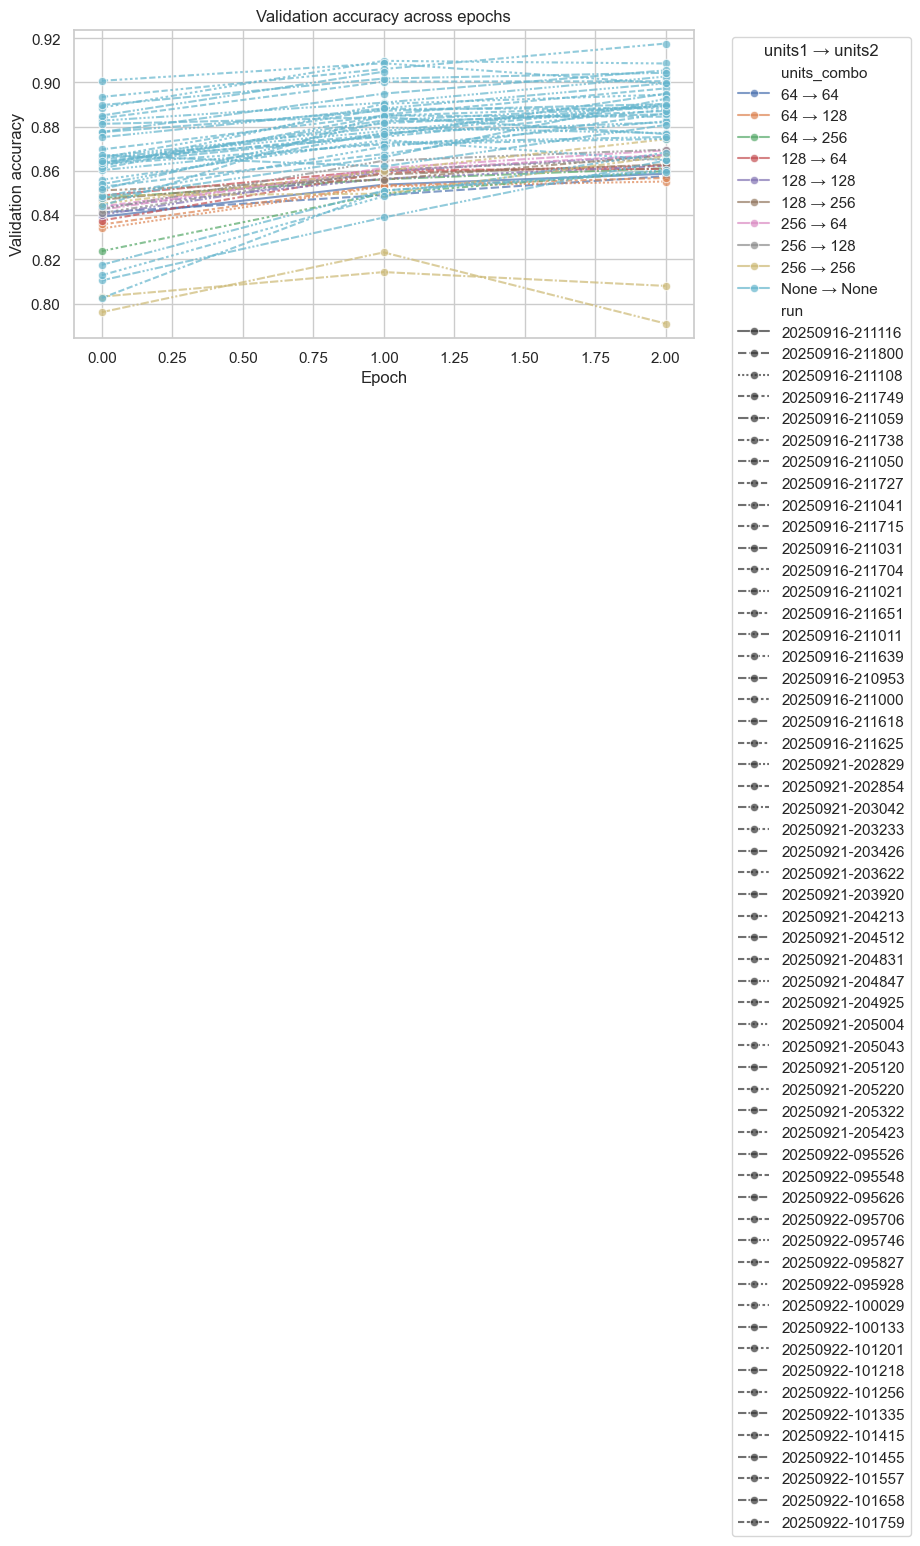

In [34]:
def plot_metric(tag: str, ylabel: str) -> None:
    metric_df = history_df[history_df["tag"] == tag]
    if metric_df.empty:
        raise KeyError(f"No scalar data found for {tag!r}.")

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(
        data=metric_df,
        x="step",
        y="value",
        hue="units_combo",
        style="run",
        marker="o",
        alpha=0.7,
        ax=ax,
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} across epochs")
    ax.legend(title="units1 → units2", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

plot_metric("Loss/train", "Training loss")
plot_metric("Loss/test", "Validation loss")
plot_metric("metric/Accuracy", "Validation accuracy")
